# CHASM (CHerenkov Air Shower Model) Demo
## Hypothetical Tau Primary Upward Air Shower
This notebook shows how to use the CHASM program to simulate the Cerenkov light profile of an air shower using universality. First import some stuff we'll need, including CHASM itself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CHASM import CHASM
%matplotlib inline

Now we need to define our array of telescopes. These need to be ahead of the shower to see any Cherenkov light. The origin of the CHASM coordinate system is where the shower axis intersects with Earth's surface. The z axis is vertical from that point, x axis is north, and y axis is west. It is convenient to define the shower axis using spherical coordinates, where we use the standard physics convention (theta is the polar angle measured down from the z axis). 

In this case, we will be simulating an tau primary air shower (upward going) from the charged-current decay of an Earth skimming tau neutrino. We want to simulate detectors in orbit, ~500 km above Earth's surface, which corresponds to ~2000 km along an axis with an 85 degree polar angle (see figure below). We create an array of detectors perpendicular to the shower axis (arrayed on the y axis) at this point in space.

In [2]:
r = 2141673
theta = np.radians(85)
arc = np.radians(2)
phi = 0
tel_vectors = np.empty([10000,3])
theta_tel, phi_tel = np.mgrid[theta-arc:theta+arc:100j, -arc:arc:100j]

tel_vectors[:,0] = r * np.sin(theta_tel.flatten()) * np.cos(phi_tel.flatten())
tel_vectors[:,1] = r * np.sin(theta_tel.flatten()) * np.sin(phi_tel.flatten())
tel_vectors[:,2] = r * np.cos(theta_tel.flatten())

Now we input the shower parameters.
 - X_max: Depth along axis of shower maximum (g/cm^2)
 - N_max: Number of charged particles at shower maximum
 - h0: Height of first interaction above the ground level (meters)
 - theta: Polar angle of shower. (radians)
 - direction: Shower direction, either 'up' for upward going showers, or 'down' for downward going showers.
 - tel_vectors: User defined array of cartesian telescope locations.
 - min_l: Minimum accepted Cherenkov wavelength.
 - max_l: Maximum accepted Cherenkov wavelength.
 
 And instantiate CHASM

In [3]:
ch = CHASM(765,8.e7,1.e3,theta,'up',tel_vectors,300,600)

Now we have the shower and its cherenkov profile at our detectors. Let's plot some stuff. First, lets look at the shower in space. We will look at the shower and telescope locations relative to Earth's surface. First let's get the axis in cartesian coordinates directly from CHASM attributes. The array of distances along the shower axis is stored in the attribute 'axis_r.' We use the 'theta' and 'phi' to complete this definiton.

In [4]:
axis_r = np.linspace(0,r,100)

x_full_axis = axis_r * np.sin(ch.theta) * np.cos(ch.phi)
y_full_axis = axis_r * np.sin(ch.theta) * np.sin(ch.phi)
z_full_axis = axis_r * np.cos(ch.theta)

x_axis = ch.axis_r * np.sin(ch.theta) * np.cos(ch.phi)
y_axis = ch.axis_r * np.sin(ch.theta) * np.sin(ch.phi)
z_axis = ch.axis_r * np.cos(ch.theta)

In order to time calculations in the atmosphere, we need to know how long a given Cherenkov photon bunch spends in each region of the atmosphere as it propagates to the counter location. We do this by calculating how long a photon would take to propagate vertically (since our atmospheric index of refraction delta is defined at various heights) then dividing by each unique propagation cosine. In order to obtain this cosine, we need to correct the propagation angles from our vector calculations, as they were relative to our original z-axis, not vertical in the atmosphere the bunch's origin location. This can be accomplished via the law of cosines on the inscribed triangle.

$$ \cos\theta' = \frac{h^2 + r^2 + 2Rh}{2r(R + h)} $$

![Theta Correction](theta_correction.png)

Now let's define the Earth's surface.

In [5]:
arc_angle = 5
arc = np.linspace(-np.radians(arc_angle),3*np.radians(arc_angle),100)
x_surf = ch.earth_radius * np.sin(arc)
z_surf = ch.earth_radius * np.cos(arc) - ch.earth_radius

x_atm = (ch.earth_radius + ch.atm.maximum_height) * np.sin(arc)
z_atm = (ch.earth_radius + ch.atm.maximum_height) * np.cos(arc) - ch.earth_radius

x_shower = ch.shower_r * np.sin(ch.theta)
z_shower = ch.shower_r * np.cos(ch.theta)

x_width = -ch.shower_rms_w * np.cos(ch.theta)
z_width = ch.shower_rms_w * np.sin(ch.theta)

The portion of the axis where the shower actually occurs is stored in the attribute 'shower_r.' Let's get the shower coordinates.

In [6]:
x_shower = ch.shower_r * np.sin(ch.theta) * np.cos(ch.phi)
y_shower = ch.shower_r * np.sin(ch.theta) * np.sin(ch.phi)
z_shower = ch.shower_r * np.cos(ch.theta)

In [7]:
x_width = -ch.shower_rms_w * np.cos(ch.theta)
z_width = ch.shower_rms_w * np.sin(ch.theta)

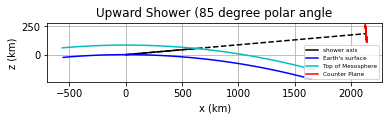

In [8]:
fig = plt.figure()
ax = plt.gca()
plt.plot(x_full_axis/1.e3,z_full_axis/1.e3, '--', color='k')
plt.plot(x_axis/1.e3,z_axis/1.e3,'k',label='shower axis' )
plt.plot(x_surf/1.e3,z_surf/1.e3,'b',label="Earth's surface")
plt.plot(x_atm/1.e3,z_atm/1.e3,'c',label="Top of Mesosphere")
plt.plot(ch.tel_vectors[:,0]/1.e3,ch.tel_vectors[:,2]/1.e3,'r', label='Counter Plane')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.legend(fontsize = 'xx-small')
plt.title('Upward Shower (85 degree polar angle')
ax.set_aspect('equal')
plt.grid()

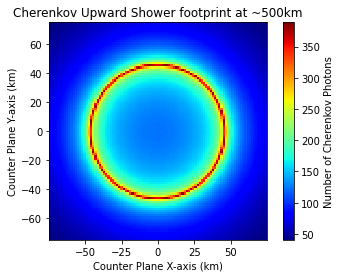

In [9]:
fig = plt.figure()
cx = r*phi_tel.flatten()*1.e-3
cy = r*theta_tel.flatten()*1.e-3
h2d = plt.hist2d(cx,cy-np.median(cy),weights=ch.ng_sum,bins=100, cmap=plt.cm.jet)
plt.title('Cherenkov Upward Shower footprint at ~500km')
plt.xlabel('Counter Plane X-axis (km)')
plt.ylabel('Counter Plane Y-axis (km)')
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar(label = 'Number of Cherenkov Photons')

Text(0.5, 1.0, 'Effect of Arrival Time Correction')

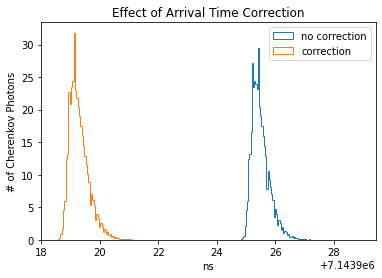

In [10]:
plt.figure()
hb = plt.hist(ch.counter_time[ch.ng_sum.argmax()],
                      100,
                      weights=ch.ng[ch.ng_sum.argmax()],
                      histtype='step',label='no correction')
hc = plt.hist(ch.counter_time_prime[ch.ng_sum.argmax()],
                      100,
                      weights=ch.ng[ch.ng_sum.argmax()],
                      histtype='step',label='correction')
plt.xlabel('ns')
plt.ylabel('# of Cherenkov Photons')
plt.legend()
plt.title('Effect of Arrival Time Correction')